In [1]:
%pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install tensorflow -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade setuptools -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import string

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [6]:
labeled_train_df = pd.read_csv("labeled_training_incidents.csv").rename(columns={"Unnamed: 0": "index"})
print(labeled_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             5082 non-null   int64 
 1   year              5082 non-null   int64 
 2   month             5082 non-null   int64 
 3   day               5082 non-null   int64 
 4   country           5082 non-null   object
 5   title             5082 non-null   object
 6   text              5082 non-null   object
 7   hazard-category   5082 non-null   object
 8   product-category  5082 non-null   object
 9   hazard            5082 non-null   object
 10  product           5082 non-null   object
dtypes: int64(4), object(7)
memory usage: 436.9+ KB
None


In [7]:
labeled_valid_df = pd.read_csv("labeled_validation_incidents.csv").rename(columns={"Unnamed: 0": "index"})
labeled_test_df = pd.read_csv("labeled_test_incidents.csv").rename(columns={"Unnamed: 0": "index"})

encode categorical columns before passing them to the classifier. <br>
one hot encoding for country (It's particularly suitable for nominal categorical features, where the categories have no inherent order or ranking.) <br>
Be aware of the "dummy variable trap," where multicollinearity can occur if one column can be predicted from the others..To avoid this, you can safely drop one of the one-hot encoded columns, reducing the dimensionality by one. You can declare the drop_first=True in the get_dummies function as shown below.<br>
Binary Encoding


https://kantschants.com/complete-guide-to-encoding-categorical-features#

In [8]:
# for i in range(1):  # Iterate over the first two rows
#     print(f"Row {i+1}:")
#     print("Title:", labeled_train_df.loc[i, 'title'])
#     print("Text:", labeled_train_df.loc[i, 'text'])
#     print("-" * 80)  # Separator for readability

In [9]:
# Extract unique hazard-category values and create a list
unique_hazard_categories = labeled_train_df["hazard-category"].unique().tolist()

# Create a mapping dictionary
hazard_category_mapping = {category: idx for idx, category in enumerate(unique_hazard_categories)}

# Create a new dataframe with text and hazard_category_label
train_st1_hazard = labeled_train_df[['text']].copy()
train_st1_hazard['label'] = labeled_train_df['hazard-category'].map(hazard_category_mapping)
print(train_st1_hazard.head())


                                                text  label
0  Case Number: 024-94   \n            Date Opene...      0
1  Case Number: 033-94   \n            Date Opene...      0
2  Case Number: 014-94   \n            Date Opene...      0
3  Case Number: 009-94   \n            Date Opene...      1
4  Case Number: 001-94   \n            Date Opene...      1


In [10]:
# Create a new dataframe with text and hazard_category_label
valid_st1_hazard = labeled_valid_df[['text']].copy()
valid_st1_hazard['label'] = labeled_valid_df['hazard-category'].map(hazard_category_mapping)
print(valid_st1_hazard.head())

# Create a new dataframe with text and hazard_category_label
test_st1_hazard = labeled_test_df[['text']].copy()
test_st1_hazard['label'] = labeled_test_df['hazard-category'].map(hazard_category_mapping)
print(test_st1_hazard.head())

                                                text  label
0  Case Number: 017-94   \n            Date Opene...      0
1  Case Number: 048-94   \n            Date Opene...      0
2  Case Number: 032-95   \n            Date Opene...      0
3  PRESENCE OF UNDECLARED NUTS IN ORIGINALE AUGUS...      5
4  Case Number: 018-98  Recall Notification Repor...      1
                                                text  label
0  Case Number: 039-94   \n            Date Opene...      0
1  Case Number: 026-95   \n            Date Opene...      0
2  Case Number: 028-95   \n            Date Opene...      0
3  PRA No. 1998/3500 Date published 17 Mar 1998 P...      0
4  PRA No. 1998/3645 Date published 10 Sep 1998 P...      1


TF-IDF ENCODING

In [11]:
max_features = 20000
def get_model(max_tokens=max_features, hidden_dim=256): 
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs) #σωστό
    x = layers.Dropout(0.5)(x)
    # Extra hidden layer
    x = layers.Dense(hidden_dim // 2, activation="relu")(x)  
    x = layers.Dropout(0.5)(x) 
    
    outputs = layers.Dense(10, activation="softmax")(x)  # 10 categories

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy']
                  )
    return model

In [12]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '\n            ', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [14]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=20000,
    ngrams=2,
    output_mode="tf_idf"
)

In [15]:
# Ensure tensors are explicitly set
train_st1_hazard_ds = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(train_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(train_st1_hazard["label"].values, dtype=tf.int32)
))

# Apply mapping
text_only_train_st1_hazard_ds = train_st1_hazard_ds.map(lambda x, y: tf.cast(x, tf.string))


In [16]:
vectorize_layer.adapt(text_only_train_st1_hazard_ds)
# Ensure tensors are explicitly set
train_st1_hazard = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(train_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(train_st1_hazard["label"].values, dtype=tf.int32)
))

valid_st1_hazard = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(valid_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(valid_st1_hazard["label"].values, dtype=tf.int32)
))

test_st1_hazard = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(test_st1_hazard["text"].values, dtype=tf.string),
    tf.convert_to_tensor(test_st1_hazard["label"].values, dtype=tf.int32)
))

tfidf_2gram_train_ds = train_st1_hazard.map(
    lambda x, y: (vectorize_layer(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

tfidf_2gram_val_ds = valid_st1_hazard.map(
    lambda x, y: (vectorize_layer(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

tfidf_2gram_test_ds = test_st1_hazard.map(
    lambda x, y: (vectorize_layer(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

2025-02-07 20:33:51.875187: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
BATCH_SIZE = 32  # or any value that fits your GPU/memory

opt_train_ds = tfidf_2gram_train_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
opt_val_ds = tfidf_2gram_val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# opt_train_ds = tfidf_2gram_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# opt_val_ds = tfidf_2gram_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

model = get_model()
history = model.fit(opt_train_ds,
                    validation_data=opt_val_ds,
                    epochs=10)

Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4851 - loss: 2.8880 - val_accuracy: 0.8283 - val_loss: 0.7042
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7408 - loss: 1.0043 - val_accuracy: 0.8655 - val_loss: 0.5237
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7992 - loss: 0.7346 - val_accuracy: 0.8690 - val_loss: 0.4496
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8396 - loss: 0.5947 - val_accuracy: 0.8779 - val_loss: 0.4348
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8526 - loss: 0.5764 - val_accuracy: 0.8850 - val_loss: 0.4090
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8842 - loss: 0.5021 - val_accuracy: 0.8743 - val_loss: 0.4319
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8937 - loss: 0.4056 - val_accuracy: 0.9044 - val_loss: 0.3959
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8968 - loss: 0.3708 - val_accu

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,308,886 (39.33 MB)

 Trainable params: 5,154,442 (19.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,154,444 (19.66 MB)

In [21]:
def history_plotter(history):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

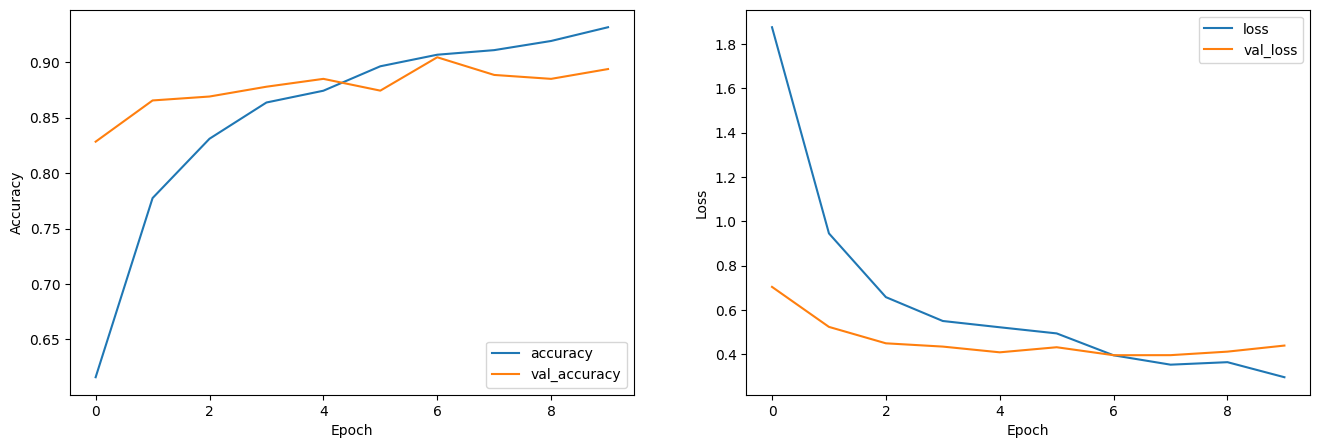

In [22]:
history_plotter(history)

In [23]:
tfidf_2gram_test_ds = tfidf_2gram_test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
model.evaluate(tfidf_2gram_test_ds) # loss, accuracy

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8882 - loss: 0.4461


[0.4475945234298706, 0.9067201614379883]

## Evaluation

In [30]:
def compute_score_1(hazards_true, hazards_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )
  return f1_hazards

In [31]:
# Get predictions
predictions = model.predict(tfidf_2gram_test_ds)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [32]:
# Convert probabilities to class labels
predicted_labels = tf.argmax(predictions, axis=1).numpy()

In [33]:
# Collect true labels from the dataset
true_labels = []
for _, labels in tfidf_2gram_test_ds:
    true_labels.extend(labels.numpy())

# Convert to NumPy array
true_labels = np.array(true_labels)

2025-02-07 23:02:51.764543: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
# Generate precision, recall, and F1-score report
report = classification_report(true_labels, predicted_labels, digits=4)

# Print the report
print(report)

              precision    recall  f1-score   support

           0     0.9792    0.9621    0.9706       343
           1     0.8689    0.9550    0.9099       111
           2     0.9565    0.8462    0.8980        52
           3     0.6444    0.7733    0.7030        75
           4     0.3333    0.3000    0.3158        10
           5     0.9580    0.9370    0.9474       365
           6     0.6000    0.6000    0.6000        10
           7     0.5769    0.5769    0.5769        26
           8     0.0000    0.0000    0.0000         4
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.9067       997
   macro avg     0.5917    0.5950    0.5922       997
weighted avg     0.9071    0.9067    0.9060       997



/Users/nataliakokota/Desktop/Food Hazard Detection/Food-Hazard-Challenge/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nataliakokota/Desktop/Food Hazard Detection/Food-Hazard-Challenge/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nataliakokota/Desktop/Food Hazard Detection/Food-Hazard-Challenge/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

In [34]:
print(compute_score_1(true_labels, predicted_labels))

0.5921529938293002


In [24]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.